<a href="https://colab.research.google.com/github/UBC-Astrophysics/QEDSurface/blob/master/magnetar.py/modified_BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get the entire repository

In [1]:
# Get the entire archive (maybe you already have it)
! git clone https://github.com/UBC-Astrophysics/QEDSurface.git

fatal: destination path 'QEDSurface' already exists and is not an empty directory.


In [2]:
# change the directory if you have to
import os
os.chdir('QEDSurface/magnetar.py')


In [3]:
# update just in case
! git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/UBC-Astrophysics/QEDSurface
   c4acc58..127eb21  master     -> origin/master
Updating c4acc58..127eb21
Fast-forward
 magnetar.py/modified_BB.ipynb | 682 +++++++++++++++++++++++++++---------------
 1 file changed, 441 insertions(+), 241 deletions(-)


# Load Libraries

In [4]:
import Magnetar
import numba
import numpy as np
import matplotlib.pyplot as plt

# Create the double black-body surface map

In [5]:
#mysurfmodel=Magnetar.dipole_model(Magnetar.condensed_surface,1,1e13,70565.,fixed_ions=False)
mysurfmodel=Magnetar.dipole_model(Magnetar.modified_bb_atmo,0.6,1.25e14,freq_power=2,sigma_power=4/13,kb_suppress=True,limb_darkening=True)


/content/QEDSurface/magnetar.py/Magnetar/simple_atmospheres.py:5: RuntimeWarning: overflow encountered in expm1
  return 208452.792 * ee**3 / np.expm1(ee / tt) / 2


## Add the polar cap and its edge

In [6]:
#mysurfmodel=Magnetar.dipole_model(Magnetar.condensed_surface,1,1e13,70565.,fixed_ions=False)
# The first two are the hot spot
cap1=Magnetar.modified_bb_atmo(1.9,1.25e14,0.0,freq_power=2,sigma_power=4/13,kb_suppress=True,limb_darkening=True)
cap2=Magnetar.modified_bb_atmo(1.9,1.25e14,1,freq_power=2,sigma_power=4/13,kb_suppress=True,limb_darkening=True)
# This is just past the edge of the hot spot (so cold)
cap3=Magnetar.modified_bb_atmo(0.6,1.25e14,1.1,freq_power=2,sigma_power=4/13,kb_suppress=True,limb_darkening=True)
mysurfmodel.add_patch(cap1,0)
mysurfmodel.add_patch(cap2,2)
mysurfmodel.add_patch(cap3,2.2)
mysurfmodel.sort_patches()

/content/QEDSurface/magnetar.py/Magnetar/simple_atmospheres.py:5: RuntimeWarning: overflow encountered in expm1
  return 208452.792 * ee**3 / np.expm1(ee / tt) / 2


## Add the back of the star by copying from the front

In [7]:
aa=mysurfmodel.mcolat
# copy the front surface to the back of the star
# add the angles
mysurfmodel.mcolat=aa+[180-i for i in aa[::-1]]
# add the patches
mysurfmodel.patches=mysurfmodel.patches+mysurfmodel.patches[::-1]

# Work with a single orientation

## Load the propagation file (pfield)

In [8]:
pfield_test=Magnetar.pfield().loaddata('Sample_Pfields/pfield_models_QED/pfield_5keV_30deg')

## Calculate intensities across the image

In [9]:
pfield_test.recalculate(1.65426,mysurfmodel,gtt=(1-2*2.0/10.0)**0.5)

(14523.639474500727, -14486.308086686995)

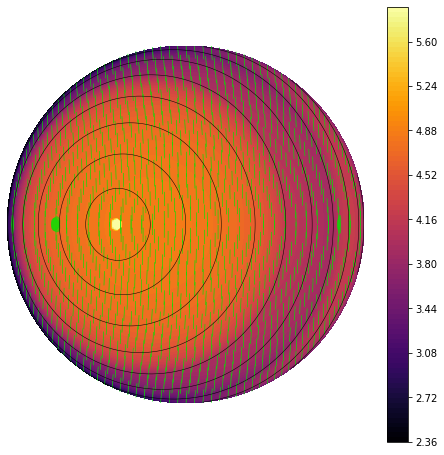

In [10]:
pfield_test

In [11]:
# calculate the mean intensity over the surface for a range of photon energies
pfield_test.calcvalues(mysurfmodel,gtt=(1-2*2.0/10.0)**0.5)


/content/QEDSurface/magnetar.py/Magnetar/simple_atmospheres.py:5: RuntimeWarning: overflow encountered in expm1
  return 208452.792 * ee**3 / np.expm1(ee / tt) / 2


## Let's do some plots

In [12]:
# load a datafile
datae,dataf=np.loadtxt('4U_0142+614.dat',unpack=True,usecols=(0,1))

In [13]:
# get the mean intensities and energy bins for the orientation
ee=pfield_test.ebins
ivec=pfield_test.iint
qvec=pfield_test.qint
# load a file with the interstellar absorption model
eabs,sabs=np.loadtxt('tbabs.dat',unpack=True)
sabs=sabs
ii=np.argsort(eabs)
eabs=eabs[ii]
sabs=sabs[ii]
# absorption cross-section per hydrogen atom in units of 1e-24 cm^2 for our energy bins
ssabs=np.interp(ee,eabs,sabs)/(ee)**3*1e-24
# the best-fit hydrogen column is 0.52e22 /cm2
totabs=np.exp(-0.6e22*ssabs)

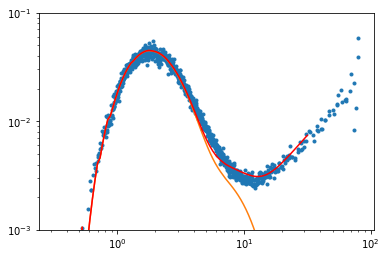

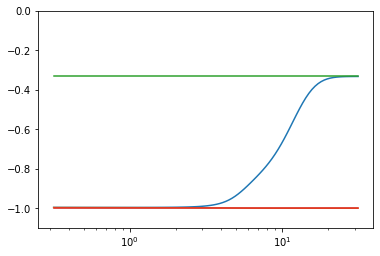

In [14]:
# plot the model against the data
norm=2.5e5
plt.loglog(datae,dataf,'.')
plt.loglog(ee,totabs*ivec/norm)
plt.loglog(ee,totabs*(ivec/norm+ee**1.3/1.2e4),'r')
plt.ylim(1e-3,1e-1)
plt.show()
plt.plot(ee,(-ee**1.3/1.2e4/3+qvec/norm)/(ivec/norm+ee**1.3/1.2e4))
plt.plot(ee,qvec/ivec)
plt.plot([ee[0],ee[-1]],[-0.33,-0.33])
plt.plot([ee[0],ee[-1]],[-1.0,-1.0])
plt.xscale("log")
plt.ylim(-1.1,0)
plt.show()